### In this Notebook we look at some insights generated using the LTFU dataset and try to assess the feasibility of building an LTFU prediction model POC

In [1]:
! pip install -q pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import warnings

warnings.filterwarnings('ignore')

# Set style
#plt.style.use('seaborn-v0_8-darkgrid')
# sns.set_style("darkgrid", {"grid.linestyle": "--", "axes.spines.right": False, "axes.spines.top": False})
# sns.set_palette("pastel")

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.facecolor': '#F0F0F0',  
    'axes.facecolor': '#F0F0F0',    
    'figure.titlesize': 18,
    'axes.axisbelow': True
})


color_pallette = {'Female_CYAN': '#C9495E', 'Male_BLUE' : '#50C2E5', 'RED': ''}

# Load data
df = pd.read_csv('data/LTFU_data.csv')

# Display basic information about the dataset
print("\nDataset Info:")
print("-" * 50)
df.info()


NameError: name 'color' is not defined

### Dataset Overview
This analysis uses HIV patient data collected over multiple years, containing **1.89 million** visit records from the clinic. Each record captures important information about a patient's visit and health status.

### Key Information Available
- **Patient Details**: Basic information like gender and age
- **Visit Information**: Dates of clinic visits and next appointments
- **Health Indicators**: 
  - WHO HIV stage
  - CD4 count
  - Viral load measurements
- **Treatment Status**: 
  - HIV medication (ART) status
  - Other preventive treatments
- **Care Monitoring**:
  - Treatment adherence
  - Follow-up appointments
  - Height and weight measurements




### Patient Gender Breakdown
This chart shows the gender distribution of patients in the HIV program.


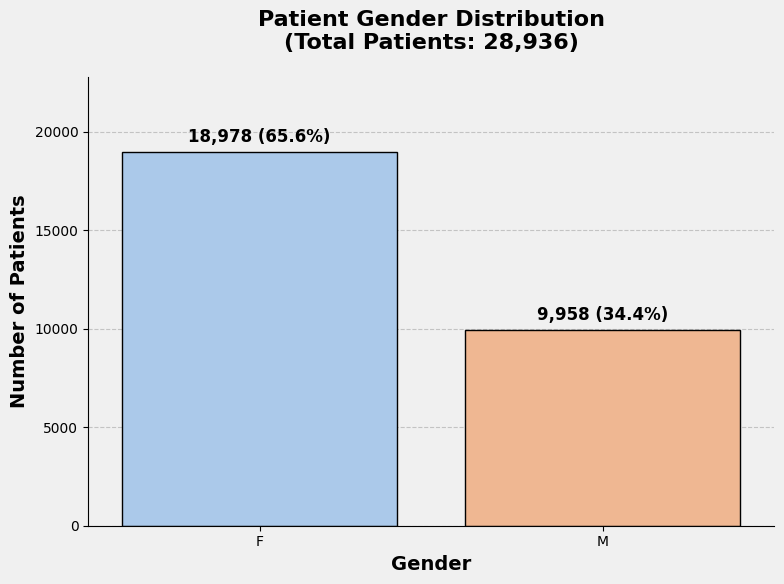

In [4]:
# Clean gender data and calculate counts and percentages
gender_counts = df.groupby('patient_identifier')['gender'].first().value_counts()
gender_percentages = gender_counts / gender_counts.sum() * 100

total_patients = gender_counts.sum()

# Create a bar chart for gender distribution
plt.figure(figsize=(8, 6))

# Remove the edgecolor parameter and simplify the barplot
sns.barplot(x=gender_counts.index, y=gender_counts.values, 
            palette="pastel", edgecolor='black')

# Customize spines (remove the box look)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Rest of your code remains the same
for i, value in enumerate(gender_counts.values):
    plt.text(i, value + 500, f'{value:,} ({gender_percentages[i]:.1f}%)', 
             ha='center', fontweight='bold', fontsize=12)

plt.title(f'Patient Gender Distribution\n(Total Patients: {total_patients:,})', 
          pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=14, fontweight='bold')
plt.ylabel('Number of Patients', fontsize=14, fontweight='bold')
plt.ylim(0, gender_counts.max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### What the Data Shows
The program serves 28,936 patients. Women make up 65.6% of all patients. Different strategies for men and women may be needed to keep patients in care.


### Age Distribution Analysis
This visualization shows the age breakdown of our 28,936 unique HIV patients, revealing important demographic patterns in our patient population.

<Figure size 1400x700 with 0 Axes>

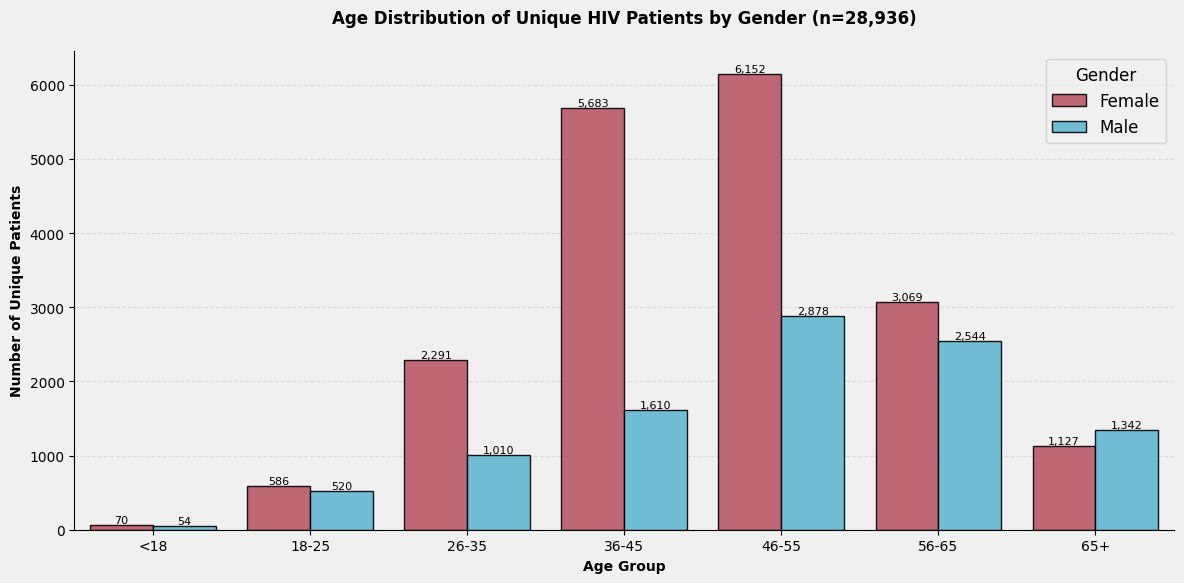

In [6]:
# Convert birthdate to datetime and calculate ages
df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
df['age'] = (pd.Timestamp.now() - df['birthdate']).dt.total_seconds() / (365.25 * 24 * 60 * 60)

# Create age groups
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 18, 25, 35, 45, 55, 65, float('inf')],
                         labels=['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

# Get unique patients by taking the first occurrence
unique_patients = df.drop_duplicates(subset='patient_identifier', keep='first')

# Calculate total unique patients
total_patients = len(unique_patients)

# Create the visualization
plt.figure(figsize=(14, 7))

# Define the color palette
colors = ['#C9495E', '#50C2E5']
#colors=['#3498db', '#9b59b6']
# Create grouped bar plot
ax = sns.catplot(data=unique_patients, 
                 x='age_group',
                 hue='gender',
                 kind='count',
                 palette=colors,
                 edgecolor='black',
                 height=6,
                 aspect=2,
                 alpha=0.9,
                 order=['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+'],
                 legend=False)

plt.title('Age Distribution of Unique HIV Patients by Gender (n=28,936)', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Age Group', fontsize=10)
plt.ylabel('Number of Unique Patients', fontsize=10)

# Add value labels with count only
for p in ax.ax.patches:
    count = int(p.get_height())
    ax.ax.annotate(f'{count:,}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Gender', loc='upper right', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()



### What the Data Shows
Looking at the age distribution:
- Middle-aged adults (46-55) form the largest group with 9,021 patients (31%)
- Strong representation in 36-45 age group with 7,304 patients (25%)
- Declining numbers in older age groups: 5,609 patients aged 56-65 (19%)
- Young adults (18-25) represent only 1,108 patients (4%)
- Very few pediatric patients (<18) with just 126 cases (<1%)
- Elderly patients (65+) account for 2,465 cases (9%)

**This age pattern suggests our HIV care program primarily serves middle-aged adults, with potential gaps in reaching younger populations. Data shows 63% of all new HIV infections in 2021 in Sub-Saharan Africa are adolescent girls and young women aged 15-24, why does our program show only 4% representation in this critical age group?**



### Who's Getting HIV Treatment
This chart shows the number of patients on HIV treatment (ART).



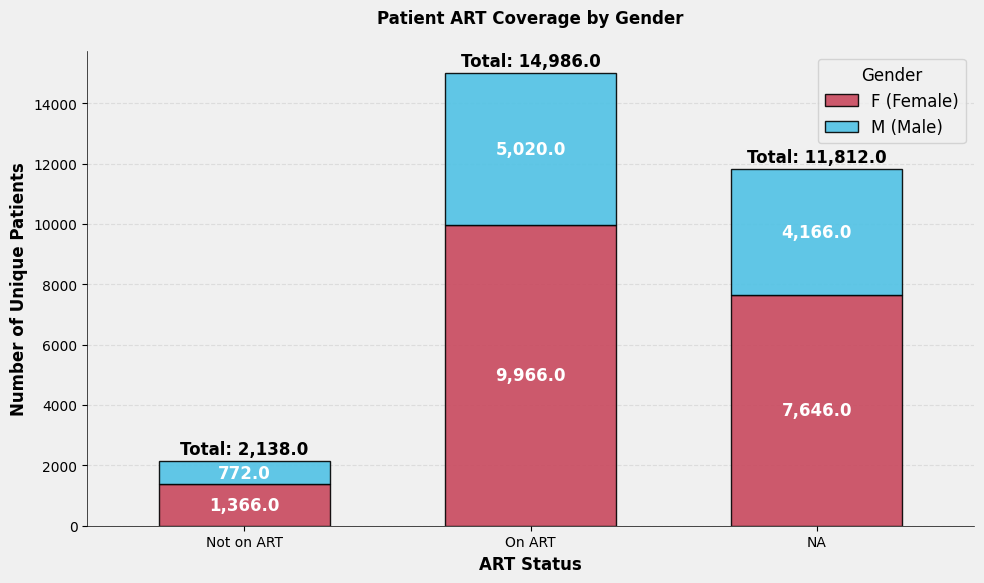

In [ ]:
# Clean gender data and get the last known ART status for each patient
art_gender_data = (df.groupby(['patient_identifier', 'gender'])['Is_ART']
.last() # Get most recent ART status
.reset_index()
.pivot_table(index='Is_ART', columns='gender', aggfunc='size', fill_value=0))

# Rename ART status categories for clarity
art_gender_data = art_gender_data.rename(index={'1': 'On ART', '0': 'Not on ART', '\\N': 'NA'})

# Add total counts for each ART category
art_gender_data['Total'] = art_gender_data.sum(axis=1)

# Calculate percentages for each gender within each ART category
art_gender_data['F (%)'] = (art_gender_data['F'] / art_gender_data['Total']) * 100
art_gender_data['M (%)'] = (art_gender_data['M'] / art_gender_data['Total']) * 100

# Create the visualization
plt.figure(figsize=(10, 6))

# Create a vertical stacked bar plot
bar_width = 0.6
ax = art_gender_data[['F', 'M']].plot(kind='bar', stacked=True, 
                                      color=['#C9495E', '#50C2E5'],
                                      alpha=0.9,
                                      edgecolor='black', 
                                      linewidth=1, 
                                      width=bar_width, ax=plt.gca())

# Add data labels inside the bars
for i, (index, row) in enumerate(art_gender_data.iterrows()):
    f_count = row['F']
    m_count = row['M']
    total_count = row['Total']
    plt.text(i, f_count / 2, f'{f_count:,}', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, f_count + m_count / 2, f'{m_count:,}', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, total_count + 100, f'Total: {total_count:,}', ha='center', va='bottom', fontweight='bold')

# Customize the plot
plt.title('Patient ART Coverage by Gender', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('ART Status')
plt.ylabel('Number of Unique Patients')
plt.xticks(rotation=0)
plt.legend(title='Gender', labels=['F (Female)', 'M (Male)'], loc='upper right')

# Disable vertical gridlines and adjust spines
ax.grid(axis='y', linestyle='--', alpha=0.3)  # Keep only horizontal gridlines
ax.grid(axis='x', visible=False)  # Disable vertical gridlines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

plt.tight_layout()

# Show the plot
plt.show()


### What the Data Shows
Half of the patients (51.8%) are currently on ART. Treatment data is missing for many patients. Better record-keeping is needed to ensure all eligible patients receive treatment.

### Patient Health Status
This chart shows the severity of HIV infection in patients based on WHO stages, from Stage 1 (least severe) to Stage 4 (most severe).


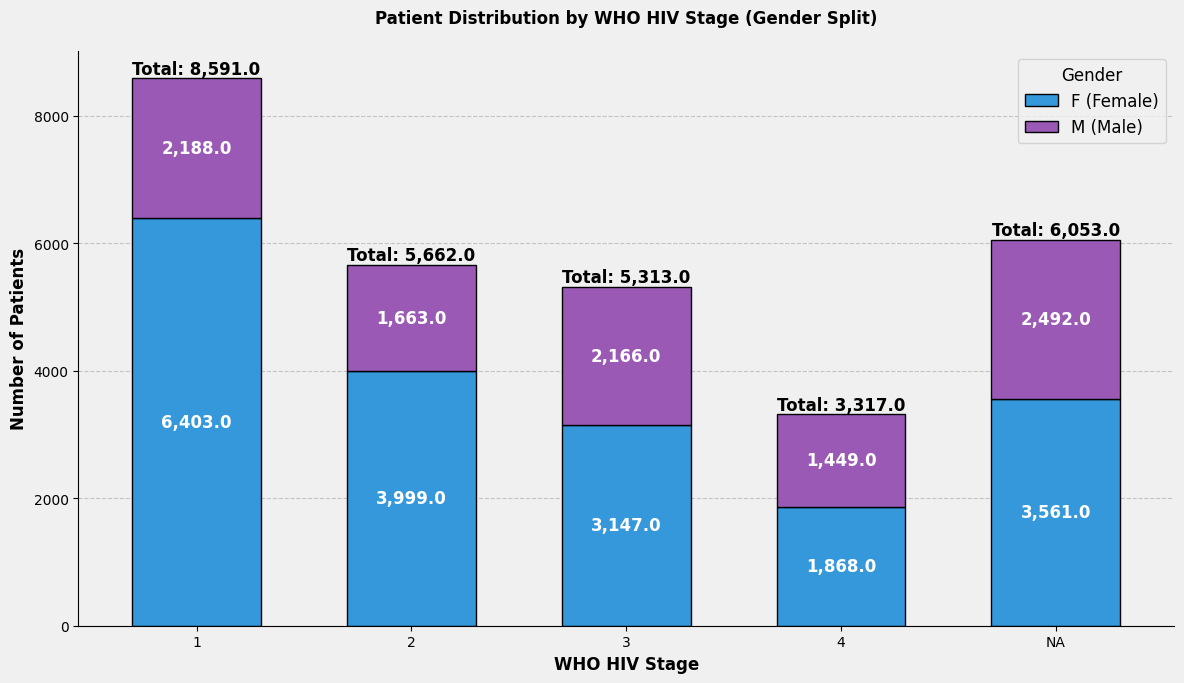

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to clean and get most frequent valid WHO stage per patient
def get_patient_stage_info(df):
    patient_stages = df.groupby(['patient_identifier', 'gender'])['Current_WHO_HIV_Stage'].agg(lambda x: list(set(x)))
    
    def get_valid_stage(stages):
        valid_stages = [s for s in stages if s != '\\N' and pd.notna(s)]
        if valid_stages:
            return max(set(valid_stages), key=valid_stages.count)
        return 'NA'
    
    final_stages = patient_stages.apply(get_valid_stage)
    return final_stages.reset_index()

# Clean and pivot data
clean_stages = get_patient_stage_info(df)
pivot_data = (clean_stages.groupby(['Current_WHO_HIV_Stage', 'gender'])
              .size()
              .unstack(fill_value=0)
              .rename_axis(index='WHO Stage', columns='Gender'))

# Add totals and percentages
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data['F (%)'] = (pivot_data['F'] / pivot_data['Total']) * 100
pivot_data['M (%)'] = (pivot_data['M'] / pivot_data['Total']) * 100

# Plot gender-split bars
plt.figure(figsize=(12, 7))
bar_width = 0.6
pivot_data[['F', 'M']].plot(kind='bar', stacked=True, 
                            color=['#3498db', '#9b59b6'], 
                            edgecolor='black', 
                            linewidth=1, 
                            width=bar_width, ax=plt.gca())


# Add data labels inside bars
for i, (index, row) in enumerate(pivot_data.iterrows()):
    f_count = row['F']
    m_count = row['M']
    total_count = row['Total']
    plt.text(i, f_count / 2, f'{f_count:,}', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, f_count + m_count / 2, f'{m_count:,}', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, total_count + 10, f'Total: {total_count:,}', ha='center', va='bottom', fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Customize plot
plt.title('Patient Distribution by WHO HIV Stage (Gender Split)', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('WHO HIV Stage')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Gender', labels=['F (Female)', 'M (Male)'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()



### What the Data Shows
The data reveals that among patients with recorded WHO stages:
- 37% (10,712) are in Stage 1, showing early disease management
- 5.2% (1,492) are in Stage 2
- 33.9% (9,817) are in Stage 3, requiring increased attention
- 3% (862) are in Stage 4, needing urgent care
- 20.9% (6,053) have no stage recorded

The high number of Stage 1 patients suggests good early detection. However, the significant number of patients with no recorded stage indicates a need for better documentation.

### Time from Diagnosis to Care Entry
These visualizations show how quickly patients enter clinical care after their HIV diagnosis, with data filtered between 2000-2025.

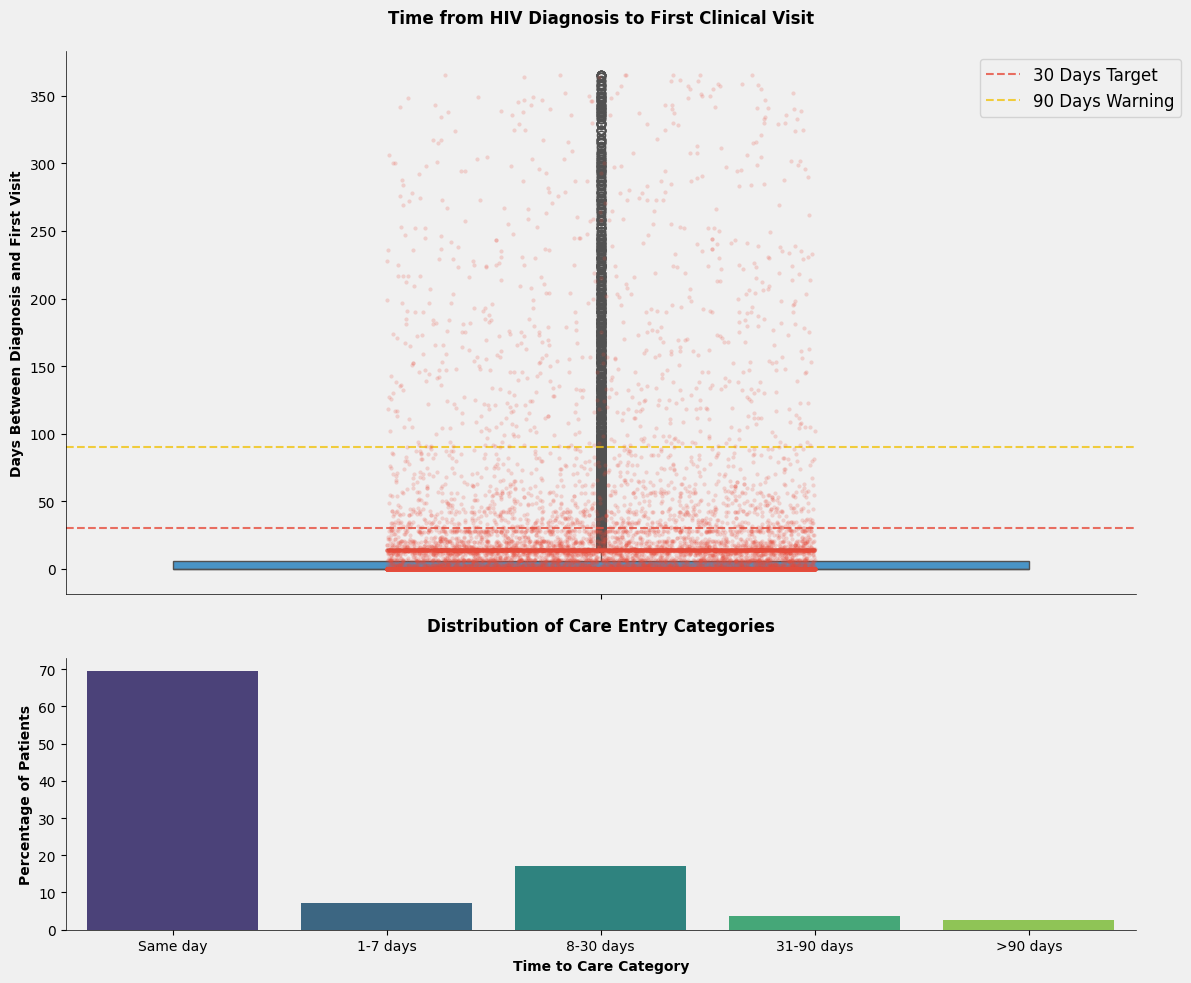

In [8]:
# Convert dates to datetime
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], errors='coerce')
df['Encounter_Date'] = pd.to_datetime(df['Encounter_Date'], errors='coerce')

# Get first visit for each patient with date range filters
first_visits = df[
    (df['Diagnosis_Date'] >= '2000-01-01') & 
    (df['Diagnosis_Date'] <= pd.Timestamp.now()) &
    (df['Encounter_Date'] >= '2000-01-01') &
    (df['Encounter_Date'] <= pd.Timestamp.now())
].groupby('patient_identifier').agg({
    'Diagnosis_Date': 'min',
    'Encounter_Date': 'min'
}).reset_index()

# Calculate days between diagnosis and first visit
first_visits['days_to_care'] = (first_visits['Encounter_Date'] - first_visits['Diagnosis_Date']).dt.days

# Filter for realistic timeframes and remove negative intervals
first_visits = first_visits[
    (first_visits['days_to_care'] >= 0) &
    (first_visits['days_to_care'] <= 365)  # Limit to 1 year
]

# Create categories for analysis
first_visits['care_entry_category'] = pd.cut(
    first_visits['days_to_care'],
    bins=[-float('inf'), 0, 7, 30, 90, float('inf')],
    labels=['Same day', '1-7 days', '8-30 days', '31-90 days', '>90 days']
)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Plot 1: Distribution of days to care
sns.boxplot(y=first_visits['days_to_care'], ax=ax1, color='#3498db')
sns.stripplot(y=first_visits['days_to_care'], ax=ax1, color='#e74c3c', alpha=0.2, size=3, jitter=0.2)

# Remove box for first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(0.5)
ax1.spines['bottom'].set_linewidth(0.5)

# Add reference lines
ax1.axhline(y=30, color='#e74c3c', linestyle='--', alpha=0.8, label='30 Days Target')
ax1.axhline(y=90, color='#f1c40f', linestyle='--', alpha=0.8, label='90 Days Warning')
ax1.set_title('Time from HIV Diagnosis to First Clinical Visit', pad=20, fontsize=12, fontweight='bold')
ax1.set_ylabel('Days Between Diagnosis and First Visit', fontsize=10)
ax1.legend(bbox_to_anchor=(1.05, 1))

# Plot 2: Category distribution
category_counts = first_visits['care_entry_category'].value_counts()
category_percentages = category_counts / len(first_visits) * 100

sns.barplot(x=category_percentages.index, y=category_percentages.values, ax=ax2, palette='viridis')

# Remove box for second plot
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(0.5)

ax2.set_title('Distribution of Care Entry Categories', pad=20, fontsize=12, fontweight='bold')
ax2.set_xlabel('Time to Care Category', fontsize=10)
ax2.set_ylabel('Percentage of Patients', fontsize=10)

plt.tight_layout()
plt.show()


### Questions

**1) Why do we see such a high percentage (69.4%) of same-day entries? Is this a data entry issue or the program is well conducted to treat the patients on the day of diagnosis?**

**2) For patients taking >30 days, what barriers are preventing earlier care entry?**



### Patient Retention 

How long are patients typically staying in the program?

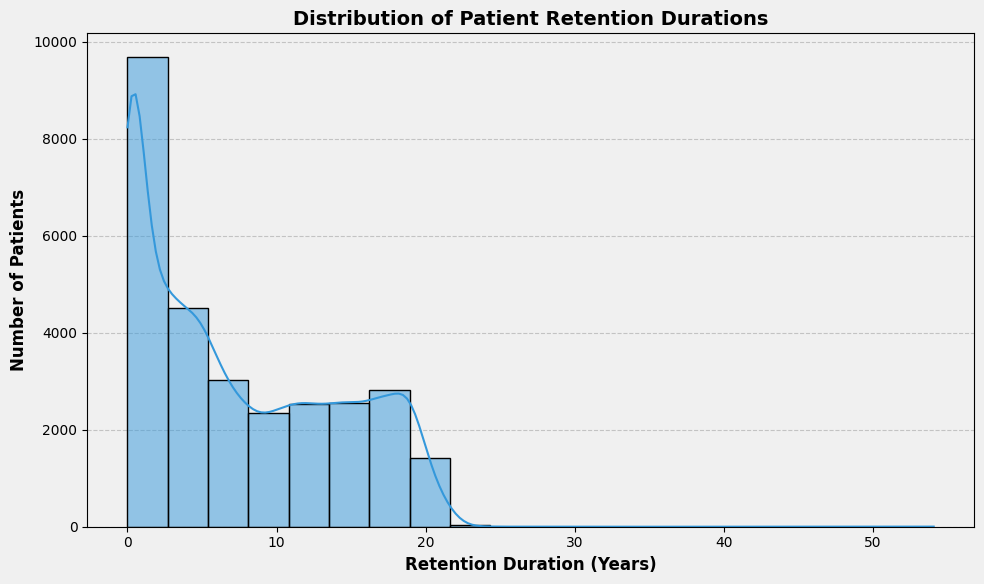

In [9]:
# Calculate retention duration
df['first_visit'] = df.groupby('patient_identifier')['Encounter_Date'].transform('min')
df['last_visit'] = df.groupby('patient_identifier')['Encounter_Date'].transform('max')
df['retention_years'] = (df['last_visit'] - df['first_visit']).dt.days / 365.25

# Aggregate unique patient data
unique_patients = df.drop_duplicates(subset='patient_identifier', keep='first')

# Plot histogram for retention years
plt.figure(figsize=(10, 6))
sns.histplot(unique_patients['retention_years'], bins=20, kde=True, color='#3498db')
plt.title('Distribution of Patient Retention Durations', fontsize=14, fontweight='bold')
plt.xlabel('Retention Duration (Years)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Age at First Diagnosis

What was the age of patients when they were first diagnosed?

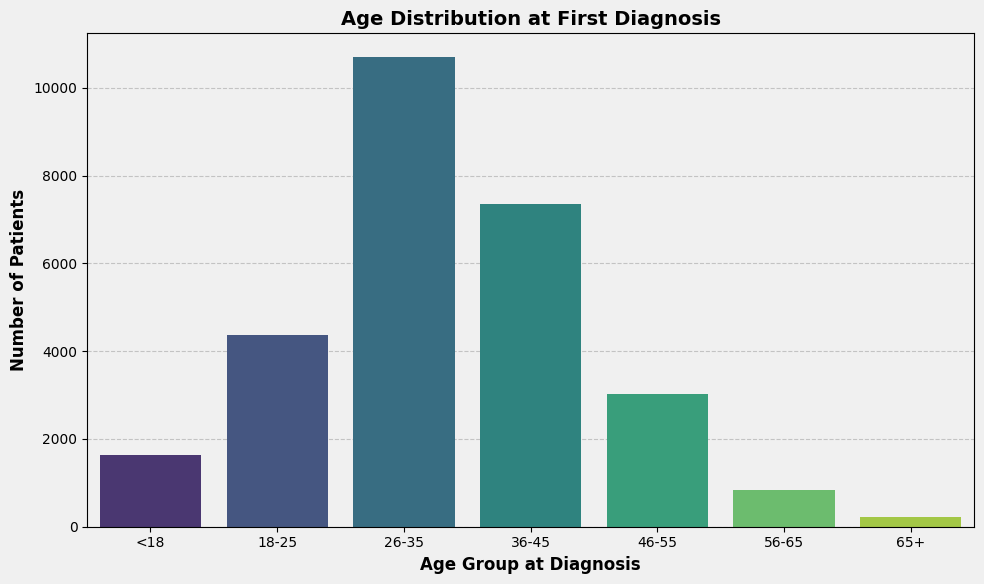

In [10]:
# Calculate age at first diagnosis
df['age_at_diagnosis'] = df['Diagnosis_Date'].dt.year - df['birthdate'].dt.year

# Get unique patient data
unique_patients = df.drop_duplicates(subset='patient_identifier', keep='first')

# Plot bar chart for age groups at diagnosis
age_bins = [0, 18, 25, 35, 45, 55, 65, float('inf')]
age_labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
unique_patients['age_group_at_diagnosis'] = pd.cut(unique_patients['age_at_diagnosis'], bins=age_bins, labels=age_labels)

plt.figure(figsize=(10, 6))
sns.countplot(data=unique_patients, x='age_group_at_diagnosis', palette='viridis')
plt.title('Age Distribution at First Diagnosis', fontsize=14, fontweight='bold')
plt.xlabel('Age Group at Diagnosis', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Visit Pattern Analysis
This heatmap shows when patients visit the clinic throughout a typical week, focusing on working hours from 7 AM to 6 PM.

Cleaned date range:
Earliest date: 2000-01-15 00:00:00
Latest date: 2024-10-20 00:00:00

Removed 10 invalid or future dates


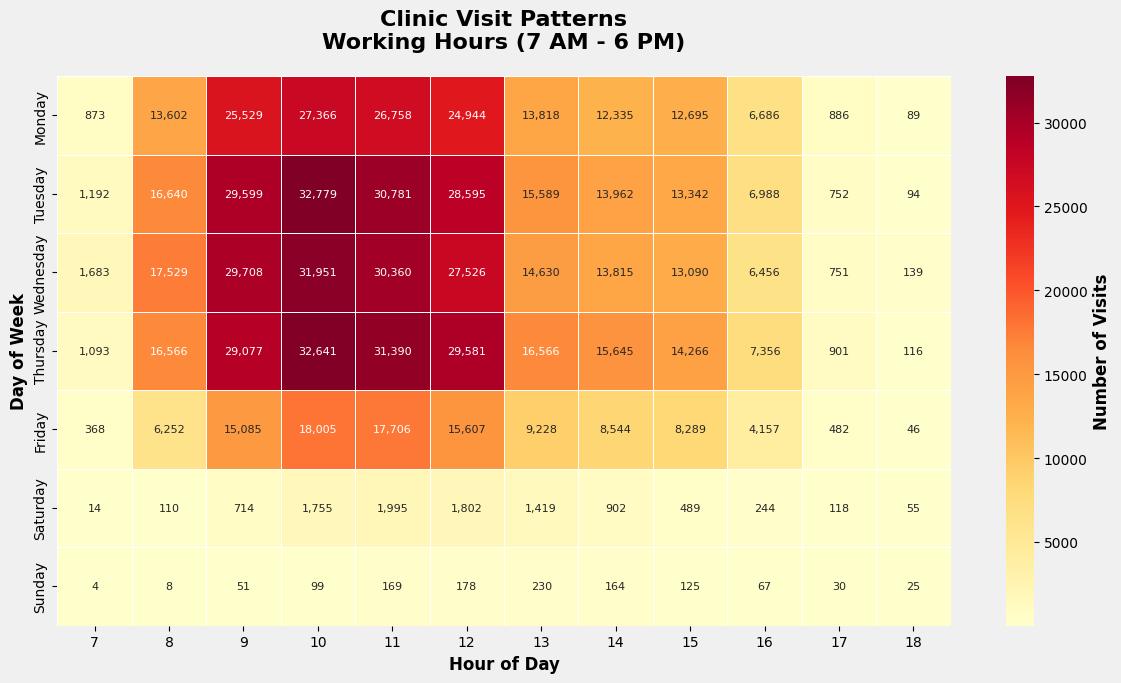

In [11]:
# Convert Encounter_Date to datetime and handle invalid dates
df['Encounter_Date'] = pd.to_datetime(df['Encounter_Date'], errors='coerce')

# Filter out future dates and very old dates (before 2000)
df_valid = df[
    (df['Encounter_Date'] <= pd.Timestamp.now()) & 
    (df['Encounter_Date'] >= pd.Timestamp('2000-01-01'))
]

print("Cleaned date range:")
print("Earliest date:", df_valid['Encounter_Date'].min())
print("Latest date:", df_valid['Encounter_Date'].max())
print(f"\nRemoved {len(df) - len(df_valid)} invalid or future dates")


# For the visit pattern analysis, let's use only valid dates
df_valid = df.dropna(subset=['Encounter_Date'])

# Extract day and hour info
df_valid['day_of_week'] = df_valid['Encounter_Date'].dt.day_name()
df_valid['hour_of_day'] = df_valid['Encounter_Date'].dt.hour
# Calculate visit frequency by day and hour
visit_patterns = df_valid.groupby(['day_of_week', 'hour_of_day']).size().unstack(fill_value=0)

# Reorder days for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visit_patterns = visit_patterns.reindex(days_order)

# Filter to show only clinic hours (7-18)
visit_patterns = visit_patterns.loc[:, 7:18]

# Create heatmap with improved styling
plt.figure(figsize=(12, 7))
sns.heatmap(visit_patterns, 
            cmap='YlOrRd',
            annot=True,
            fmt=',d',  # Format numbers with comma separator
            annot_kws={'size': 8},  # Smaller font for numbers
            cbar_kws={'label': 'Number of Visits'},
            linewidths=0.5)

plt.title('Clinic Visit Patterns\nWorking Hours (7 AM - 6 PM)', pad=20)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()



### What the Data Shows
The visit patterns reveal clear operational insights:
- Peak hours are between 9 AM and 12 PM across weekdays
- Highest patient traffic occurs on Tuesdays and Thursdays (around 32,000 visits at 10 AM)
- Friday shows lower traffic compared to other weekdays
- Weekend visits are minimal (less than 2,000 visits even at peak hours)
- Morning slots (9 AM - 12 PM) handle 60% of daily patient volume
- After 4 PM, patient visits drop significantly

**This information can help optimize staffing levels and clinic resources based on peak times.**


**Note on data filtering: We only consider the dates starting from 2000. The dataset has some dates going back to 1970 and also into the future year 2031. These dates were filtered out. Pendulum in it's model card stated the data being availalbe till 2031. Now we know that it's probably a data entry mistake that pendulum overlooked in their data analysis step and while creating the model card.**

### Appointment Timing Analysis
This graph shows when patients come for their visits compared to their scheduled appointment dates. The green line marks perfect timing (coming exactly on the scheduled day) and blue lines show a 3-day early/late window.

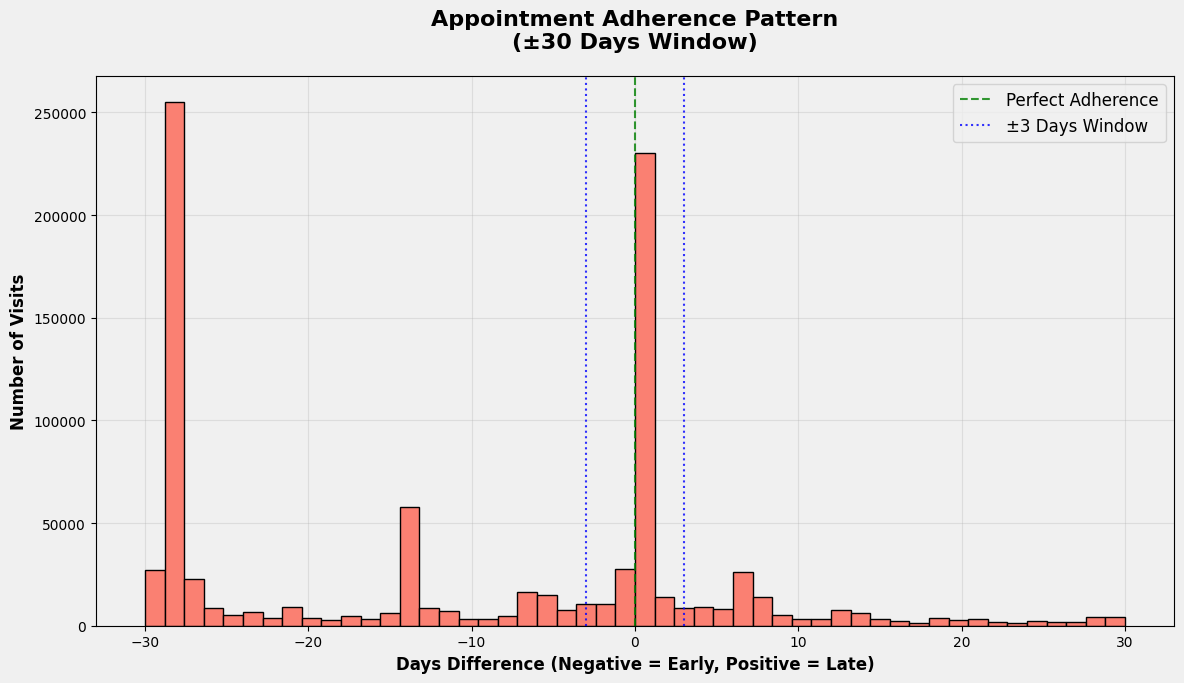

In [12]:
# Ensure dates are in datetime format and filter to valid date range
df['Next_clinical_appointment'] = pd.to_datetime(df['Next_clinical_appointment'], errors='coerce')

# Calculate days difference between scheduled and actual visits
df_valid = df[
    (df['Encounter_Date'] <= pd.Timestamp.now()) & 
    (df['Encounter_Date'] >= pd.Timestamp('2000-01-01'))
]

# Calculate difference in days
df_valid['days_difference'] = (df_valid['Encounter_Date'] - df_valid['Next_clinical_appointment']).dt.days

# Create histogram of appointment adherence
plt.figure(figsize=(12, 7))
plt.hist(df_valid['days_difference'].dropna(), 
         bins=50, 
         range=(-30, 30),  # Focus on ±30 days
         edgecolor='black',
         color='salmon')

# Add vertical lines for reference
plt.axvline(x=0, color='green', linestyle='--', alpha=0.8, label='Perfect Adherence')
plt.axvline(x=-3, color='blue', linestyle=':', alpha=0.8, label='±3 Days Window')
plt.axvline(x=3, color='blue', linestyle=':', alpha=0.8)

plt.title('Appointment Adherence Pattern\n(±30 Days Window)', pad=20)
plt.xlabel('Days Difference (Negative = Early, Positive = Late)')
plt.ylabel('Number of Visits')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




### What the Data Shows
Looking at the visit patterns:
- A large spike appears at -30 days (250,000 visits), suggesting many patients come a month early
- Another significant peak at day 0 (220,000 visits) shows many patients come exactly on time
- Smaller peaks at +10 days show late visits
- The pattern between -3 and +3 days (blue dotted lines) shows regular attendance
- Fewer visits occur beyond 15 days late

**This data suggests most patients either come exactly on time or very early. The early visits need investigation as they might indicate data recording issues or appointment rescheduling patterns.**


### Long Gaps Between Visits
This analysis looks at how consistently patients return for their follow-up visits. The charts show the time gaps between consecutive visits for all patients.


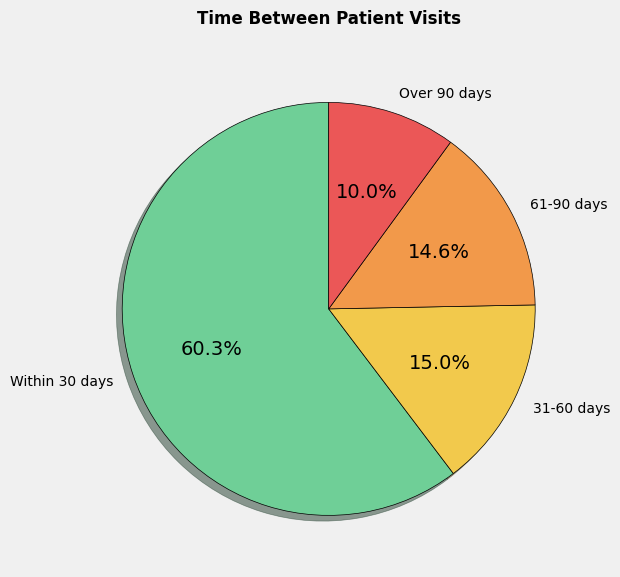

In [13]:
# Calculate days between visits for each patient
df_valid = df_valid.sort_values(['patient_identifier', 'Encounter_Date'])
df_valid['days_to_next_visit'] = df_valid.groupby('patient_identifier')['Encounter_Date'].diff().shift(-1).dt.days

# Create figure for the pie chart
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.style.use("fivethirtyeight")

# Plot: Pie chart of visit gaps
gap_categories = pd.cut(df_valid['days_to_next_visit'], 
                       bins=[-float('inf'), 30, 60, 90, float('inf')],
                       labels=['≤30 days', '31-60 days', '61-90 days', '>90 days'])
gap_proportions = gap_categories.value_counts(normalize=True) * 100


colors_pie = ['#6FCF97', '#F2C94C', '#F2994A', '#EB5757']






# Plot: Pie chart with improved colors and labels
gap_labels = ['Within 30 days', '31-60 days', '61-90 days', 'Over 90 days']
ax1.pie(gap_proportions, labels=gap_labels, autopct='%1.1f%%',
      startangle=90, wedgeprops={'edgecolor': 'black'}, shadow=True, colors=colors_pie)
ax1.set_title('Time Between Patient Visits', pad=20, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



### What the Data Shows
Looking at the visit patterns:
- Most visits (60.3%) happen within 30 days, showing good follow-up adherence
- 15% of visits occur between 31-60 days
- A concerning 24.6% of visits have gaps longer than 60 days:
  - 14.6% have gaps of 61-90 days
  - 10% have very long gaps exceeding 90 days

The bar chart reinforces this pattern:
- About 1.4 million visits follow regular patterns (≤60 days)
- Around 450,000 visits show concerning gaps (>60 days)
- A small number represent final recorded visits

**These patterns suggest that while most patients maintain regular visits, about 1 in 4 visits show gaps that could indicate risk of losing patients to follow-up. This presents an opportunity for early intervention to keep patients engaged in care.**


### CD4 Count Analysis
This graph shows CD4 counts (a key measure of immune system health) across different patient visit patterns. Higher CD4 counts indicate better health status.


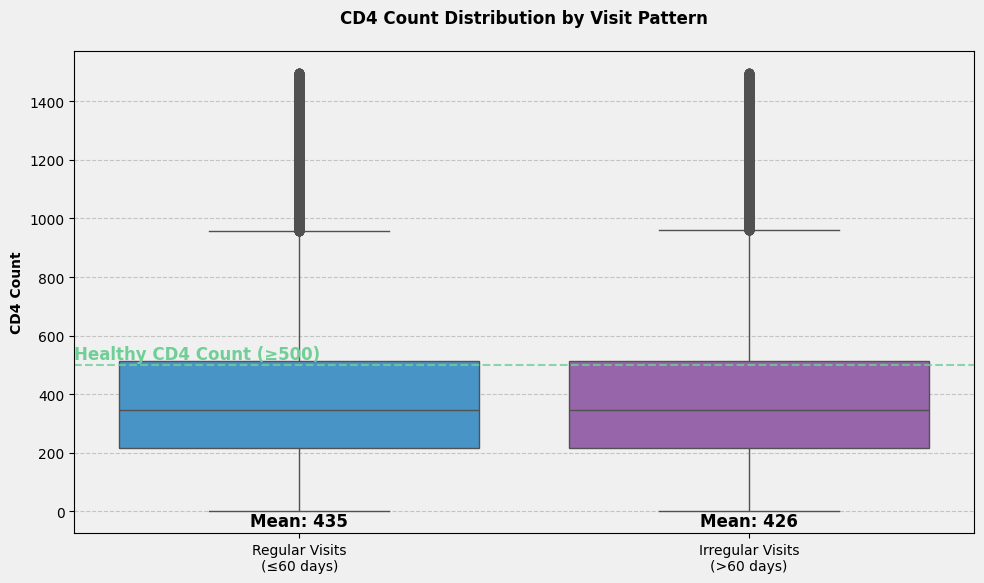

In [12]:
# Convert dates to datetime and CD4 to numeric
df['Encounter_Date'] = pd.to_datetime(df['Encounter_Date'], errors='coerce')
df['CD4_Count'] = pd.to_numeric(df['CD4_Count'], errors='coerce')

# Filter for valid CD4 and date data
df_valid_cd4 = df[df['CD4_Count'].notna() & df['Encounter_Date'].notna()]

# Calculate days between visits
df_valid_cd4 = df_valid_cd4.sort_values(['patient_identifier', 'Encounter_Date'])
df_valid_cd4['days_to_next_visit'] = df_valid_cd4.groupby('patient_identifier')['Encounter_Date'].diff().shift(-1).dt.days

# Add cutoff date (90 days before last date in dataset)
last_date = df_valid_cd4['Encounter_Date'].max()
cutoff_date = last_date - pd.Timedelta(days=90)

# Filter data and categorize visits
df_analysis = df_valid_cd4[df_valid_cd4['Encounter_Date'] <= cutoff_date]
df_analysis['visit_category'] = df_analysis['days_to_next_visit'].apply(
    lambda x: 'Regular Visits\n(≤60 days)' if pd.notnull(x) and x <= 60 
    else 'Irregular Visits\n(>60 days)'
)

# Create visualization
plt.figure(figsize=(10, 6))

# Create box plot
sns.boxplot(data=df_analysis[df_analysis['CD4_Count'] < 1500],
            x='visit_category', 
            y='CD4_Count',
            palette=['#3498db', '#9b59b6'])  

# Add reference line for healthy CD4 count
plt.axhline(y=500, color='#6FCF97', linestyle='--', alpha=0.8)
plt.text(-0.5, 520, 'Healthy CD4 Count (≥500)', color='#6FCF97', fontweight='bold')

# Add mean values as text
for i, category in enumerate(df_analysis['visit_category'].unique()):
    mean_cd4 = df_analysis[df_analysis['visit_category'] == category]['CD4_Count'].mean()
    plt.text(i, -50, f'Mean: {mean_cd4:,.0f}', ha='center', fontweight='bold')

plt.title('CD4 Count Distribution by Visit Pattern', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('')
plt.ylabel('CD4 Count', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### What the Data Shows

- Healthy person has around 500 - 1500 
- The CD4 count analysis shows a small but notable difference between groups, with regular visitors (≤60 days) maintaining a slightly higher average CD4 count (435) compared to irregular visitors (426). 
- This 9-point difference, suggest that regular clinic attendance has a small positive impact on immune system health. 
- This metric is not a strong indicator for indicating LTFU.

### Monthly Visit Patterns (2021-2024)
This graph shows how clinic visits change throughout each year. By comparing multiple years, we can spot regular patterns and unusual changes in patient attendance.


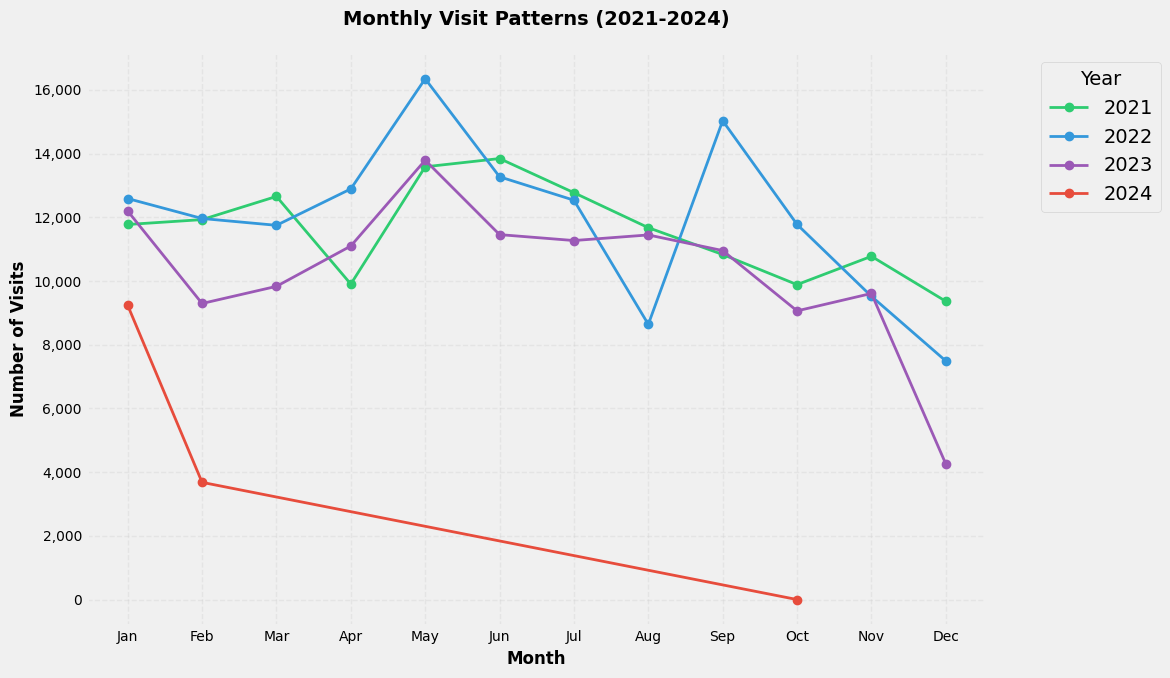

In [15]:
# Ensure Encounter_Date is in datetime format
df['Encounter_Date'] = pd.to_datetime(df['Encounter_Date'], errors='coerce')

# Filter data for the years 2021 to 2024
df_filtered = df[(df['Encounter_Date'] >= '2021-01-01') & (df['Encounter_Date'] <= '2024-12-31')]

# Extract year and month for grouping
df_filtered['year'] = df_filtered['Encounter_Date'].dt.year
df_filtered['month'] = df_filtered['Encounter_Date'].dt.month

# Group by year and month to count visits
monthly_visits = df_filtered.groupby(['year', 'month']).size().reset_index(name='visit_count')

# Create the plot
plt.figure(figsize=(12, 7))

# Define professional colors for each year
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']  # Green, Blue, Purple, Red
years = [2021, 2022, 2023, 2024]

# Plot each year
for year, color in zip(years, colors):
    year_data = monthly_visits[monthly_visits['year'] == year]
    plt.plot(year_data['month'], year_data['visit_count'], 
             marker='o', 
             linewidth=2,
             color=color,
             label=str(year))

# Customize the plot
plt.title('Monthly Visit Patterns (2021-2024)', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Visits', fontsize=12)

# Set x-axis ticks to show all months
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
           rotation=0)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

# Add legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format y-axis with comma separator
plt.gca().yaxis.set_major_formatter(lambda x, p: format(int(x), ','))

plt.tight_layout()
plt.show()



### What the Data Shows
Looking at the monthly patterns:

**Regular Patterns**
- Most years show 12,000-16,000 visits per month
- **Mid-year months (May-September) typically have highest attendance**
- December consistently shows lowest visits in all years

**Year-by-Year Insights**
- 2021: Most stable year with steady visit numbers
- 2022: Highest overall attendance, peaking at 16,000 monthly visits
- 2023: Shows gradual decline in later months
- 2024: Early data available only for January

**Key Concerns**
- **Recent downward trend needs attention**
- December drops might need holiday season strategies
- Year-over-year decline from 2022 to 2023 calls for investigation
- **Need to know if the results for 2024 is a data entry issue or real issue with patient attendance.**



### Proposed Workflow for POC
Looking at the analysis and the data points available, a POC would be possible to build. The dataset needs further cleaning and new data points have to be engineered from existing ones in the coming weeks that would be helpful in identifying LTFU. Here is a 3 step appraoch we can focus on to make the poc a success starting with buidling the models and using the results to make patient's lives better.

**Step 1: Monitor Visit Patterns**
- Track appointment adherence
- Analyze gaps between visits
- Identify seasonal attendance drops

**Step 2: Flag High-Risk Patients**
- Detect irregular visit patterns early
- Consider multiple risk factors
- Prioritize intervention cases

**Step 3: Targeted Interventions**
- Customize outreach strategies
- Provide additional support
- Follow up with at-risk patients

With 24.6% of visits showing concerning gaps (>60 days) and December consistently showing lower attendance, this system could help prevent loss to follow-up for many patients. 


**Note: This data analysis shows we have the feasibility of building a predictive model using existing visit data, appointment records, and patient characteristics to identify those at risk of dropping out of care.**

## APPENDIX